In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataset.travel_time_dataset import TravelTimeDataset
from model.early_stopping import EarlyStopping

from tsmoothie.smoother import *
import pywt
from skimage.restoration import denoise_wavelet

In [15]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 9,
        'split_type': 't',
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/attn_lstm',
    }
}

In [16]:
def expo_smooth(df):
    smoother = ExponentialSmoother(window_len=21, alpha=0.3)
    smoother.smooth(df)

    low, up = smoother.get_intervals('sigma_interval')

    print(f"lenght : {len(smoother.smooth_data[0])}")

    # plot
    plt.figure(figsize=(20, 6))
    plt.plot(df[21:], linewidth=1, color='red', alpha=0.5)
    plt.plot(smoother.smooth_data[0], linewidth=1, color='blue')
    plt.xlabel('time')

    plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
    plt.show()

def conv_smooth(df):
    # operate smoothing
    smoother = ConvolutionSmoother(window_len=21, window_type='ones')
    smoother.smooth(df)

    # generate intervals
    low, up = smoother.get_intervals('sigma_interval')

    print(f"lenght : {len(smoother.smooth_data[0])}")

    # plot
    plt.figure(figsize=(20, 6))
    plt.plot(df, linewidth=1, color='red', alpha=0.5)
    plt.plot(smoother.smooth_data[0], linewidth=1, color='blue')
    plt.xlabel('time')

    plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
    plt.show()

def kalman_smooth(df):
    # operate smoothing
    smoother = KalmanSmoother(component='level_trend', 
                            component_noise={'level':0.1, 'trend':0.1})
    smoother.smooth(df)

    # generate intervals
    low, up = smoother.get_intervals('kalman_interval')

    print(f"lenght : {len(smoother.smooth_data[0])}")

    # plot
    plt.figure(figsize=(20, 6))
    plt.plot(df, linewidth=1, color='red', alpha=0.5)
    plt.plot(smoother.smooth_data[0], linewidth=1, color='blue')
    plt.xlabel('time')

    plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
    plt.show()

In [64]:
def plot_series(series):
    plt.figure(figsize=(20, 6))
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='red')

def plot_actual(series):
    plt.figure(figsize=(25, 5), dpi=80)
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='#001f3f')

    plt.grid(b=None, which='major', axis='y', linestyle='--')

def plot_actual_2(series):
    plt.figure(figsize=(25, 5), dpi=80)
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='#FF4136')

    plt.grid(b=None, which='major', axis='y', linestyle='--')

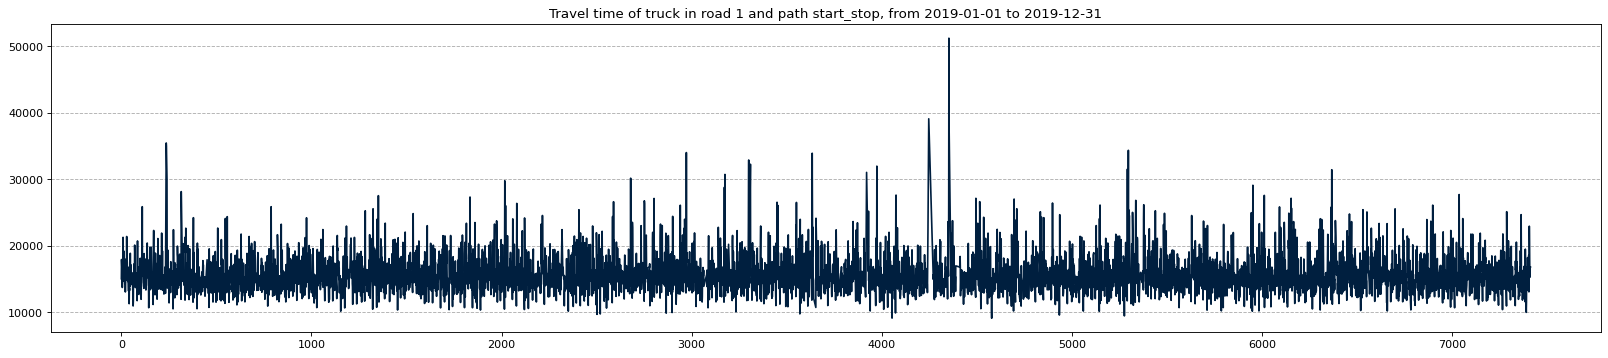

In [60]:
df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
plot_actual(df['delta_t'])

road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
path = cfg['data']['path'].split('/')[-2]
plt.title(f"Travel time of truck in road {road} and path {path}, from 2019-01-01 to 2019-12-31")

plt.show()
del df

# Load data

In [19]:
def split_data_over(cfg):
    times = [i for i in range(21)]

    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)

    if cfg['data']['split_type'] == 't':
        period = 3
        time_part = 21 // period
        time_list = [times[i * period:i * period + period] for i in range(time_part)]
        for idx, time in enumerate(time_list):
            df_tmp = df[df.index.hour.isin(time)]
            
            num_data_points_list.append(len(df_tmp))
            df_list.append(df_tmp)  
    elif cfg['data']['split_type'] == 'd':
        day_list = [[0, 1], [2, 3, 4], [5, 6]]
        for idx, day in enumerate(day_list):
            df_tmp = df[df.index.day_of_week.isin(day)]

            num_data_points_list.append(len(df_tmp))
            df_list.append(df_tmp)
            
    return df_list, num_data_points_list

In [20]:
dfs, num_data_points_list = split_data_over(cfg)

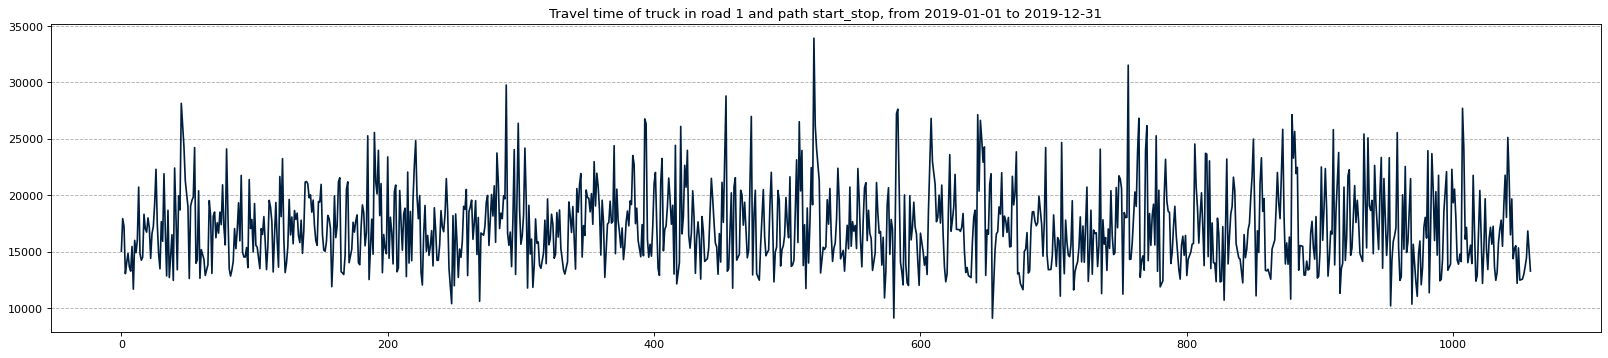

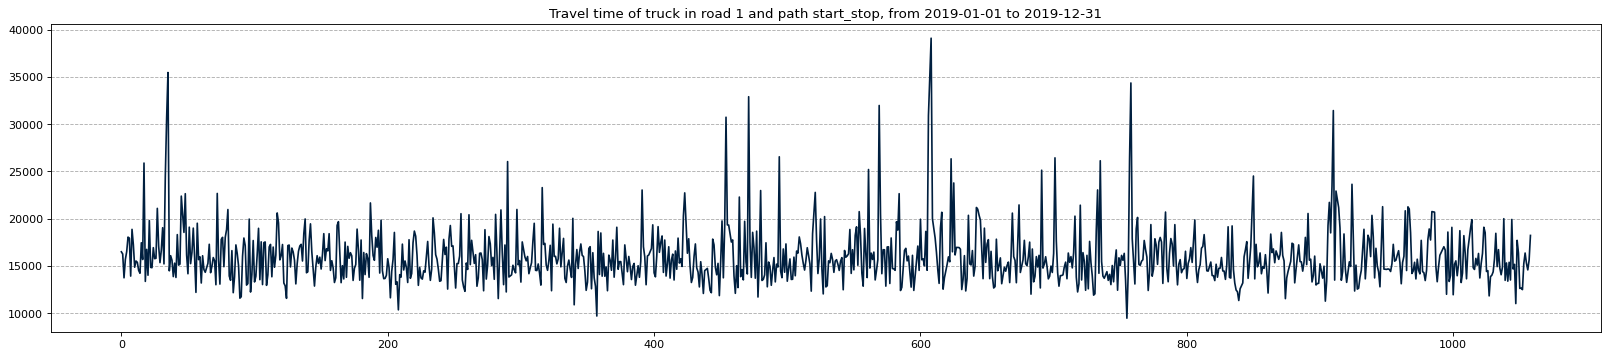

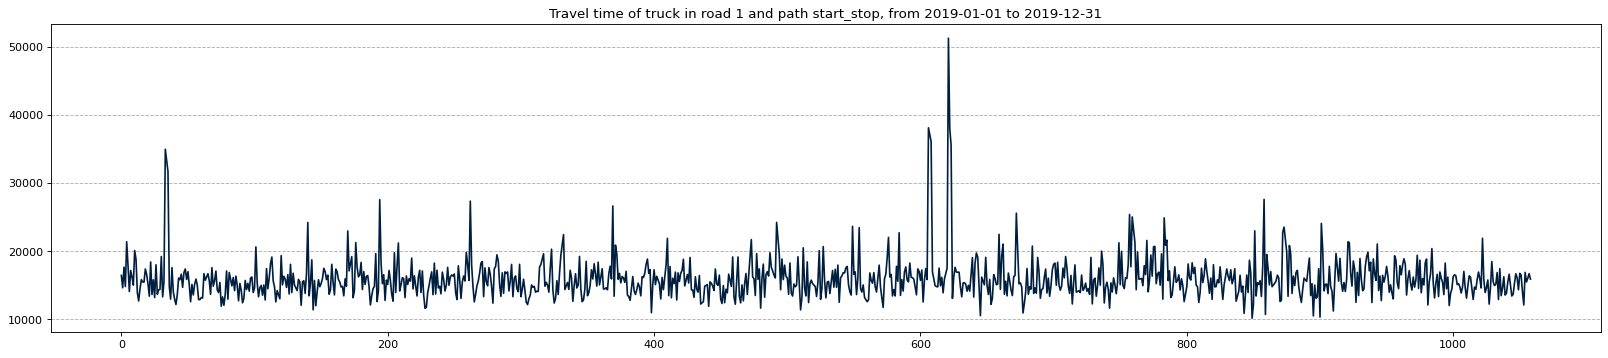

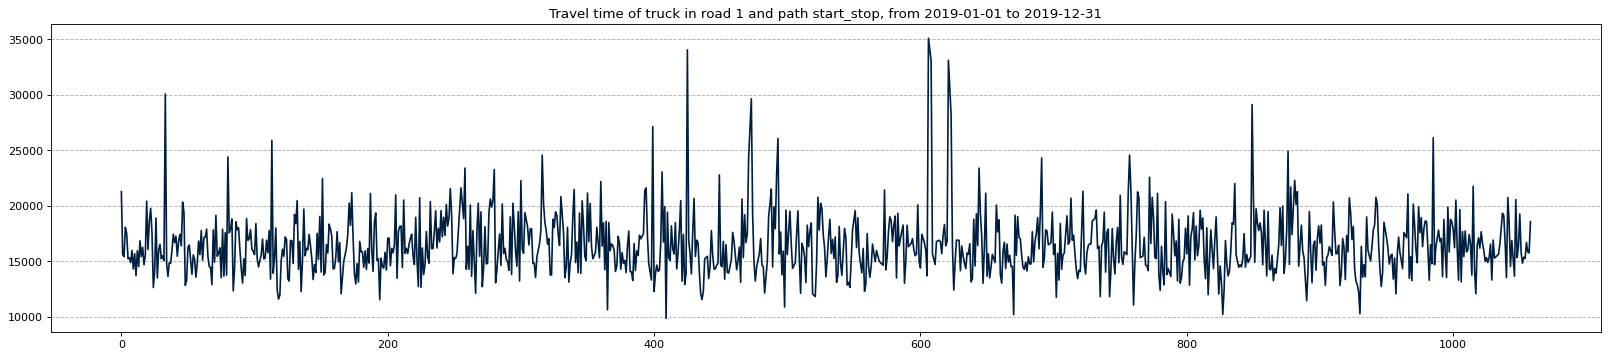

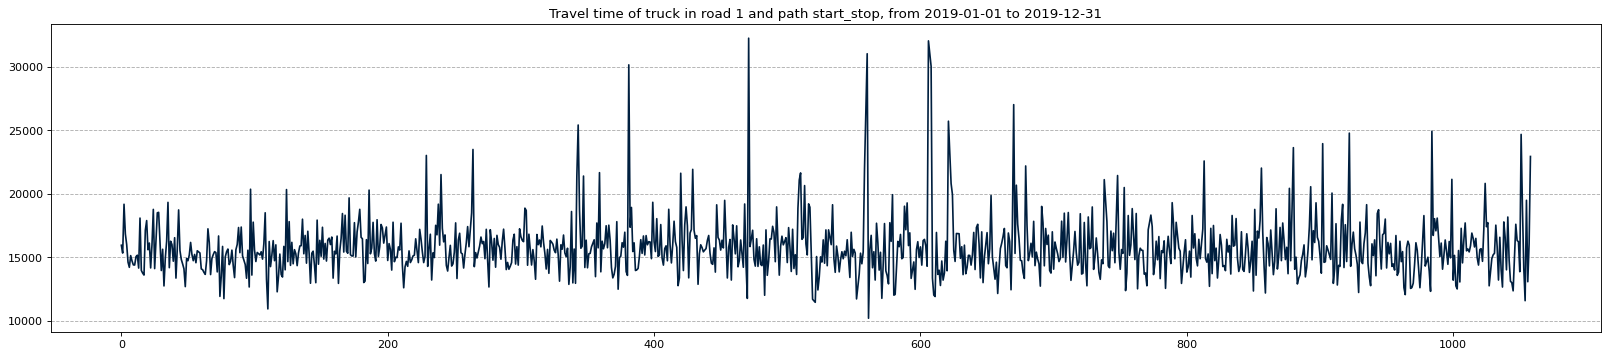

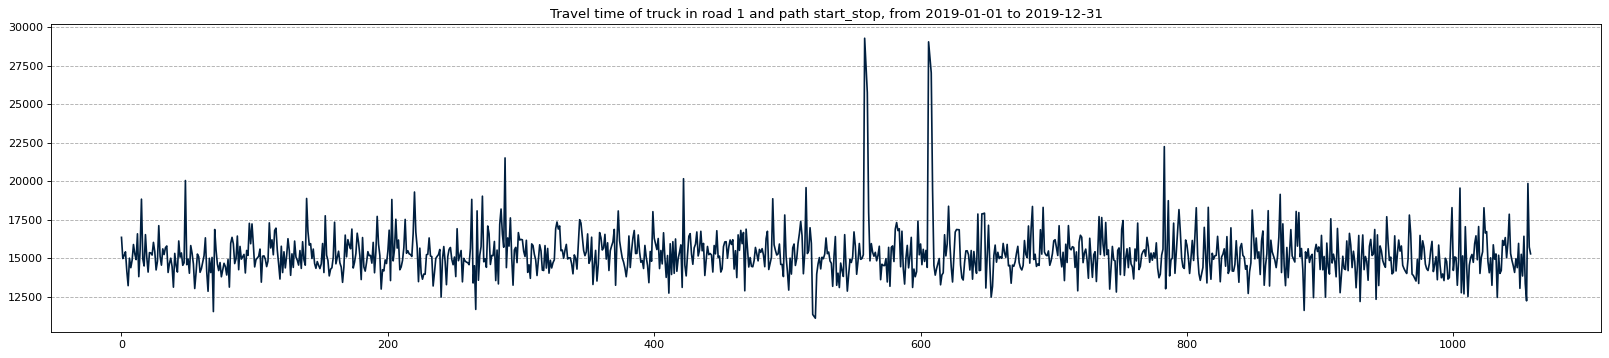

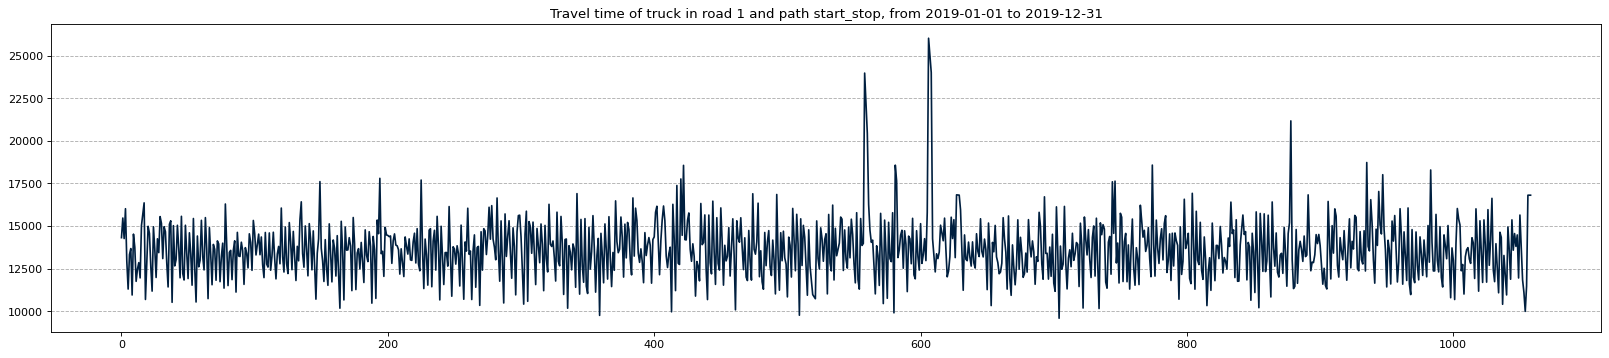

In [42]:
for idx, df in enumerate(dfs):
    plot_actual(df['delta_t'])

    road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
    path = cfg['data']['path'].split('/')[-2]
    plt.title(f"Travel time of truck in rode {road} ({path}) - show splite over 3 time of data")

    plt.show()

lenght : 1059


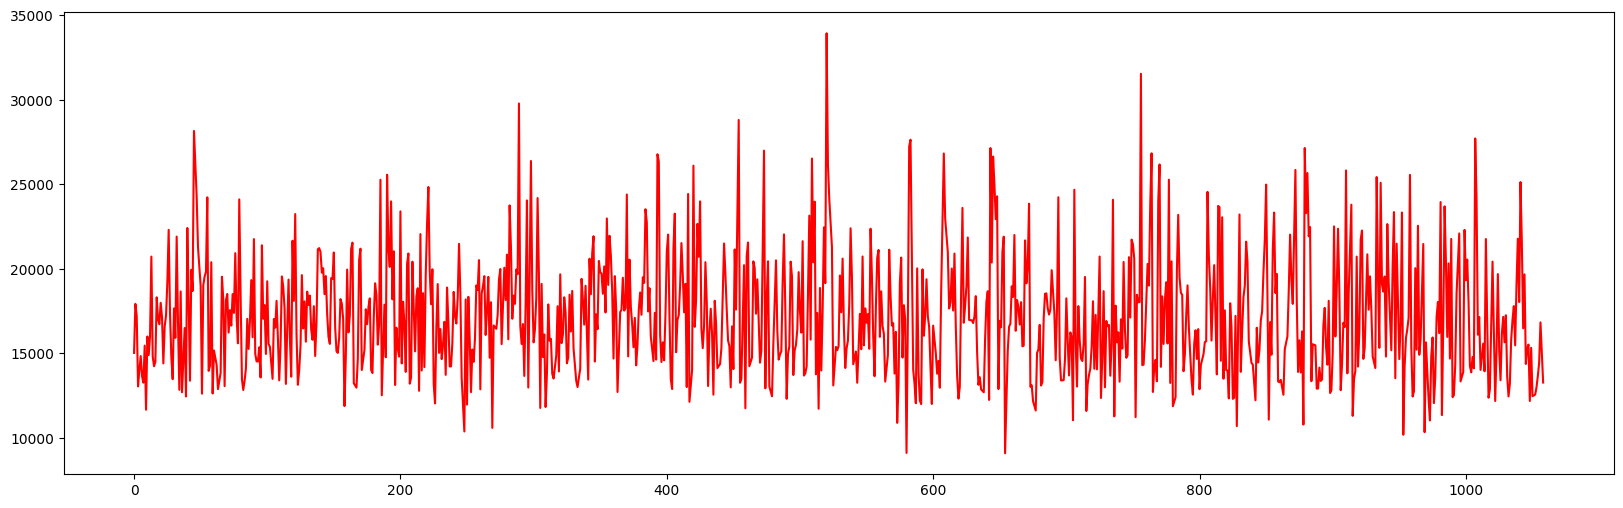

In [21]:
print(f"lenght : {len(dfs[0]['delta_t'])}")
plot_series(dfs[0]['delta_t'])
plt.show()

# Clean

In [66]:
def plot_compare(df_1, df_denoise):
    # plot
    plt.figure(figsize=(25, 5), dpi=80)
    plt.plot(df_1, color='#001F3F', alpha=0.5)
    plt.plot(df_denoise, color='#FF4136')
    plt.title(f"Travel time of truck in rode {road} ({path}) - show denoise data")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.show()

In [23]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    print(type(x))
    n = len(x)
    print(n)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    print(fft)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n

    print(PSD)
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    print(fft)
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    print(clean_data)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [24]:
def removal(signal, repeat):
    copy_signal = np.copy(signal)
    for j in range(repeat):
        for i in range(3, len(signal)):
            copy_signal[i - 1] = (copy_signal[i - 2] + copy_signal[i]) / 2
    return copy_signal

def get(original_signal, removed_signal):
    buffer = []
    for i in range(len(removed_signal)):
        buffer.append(original_signal[i] - removed_signal[i])
    return np.array(buffer)

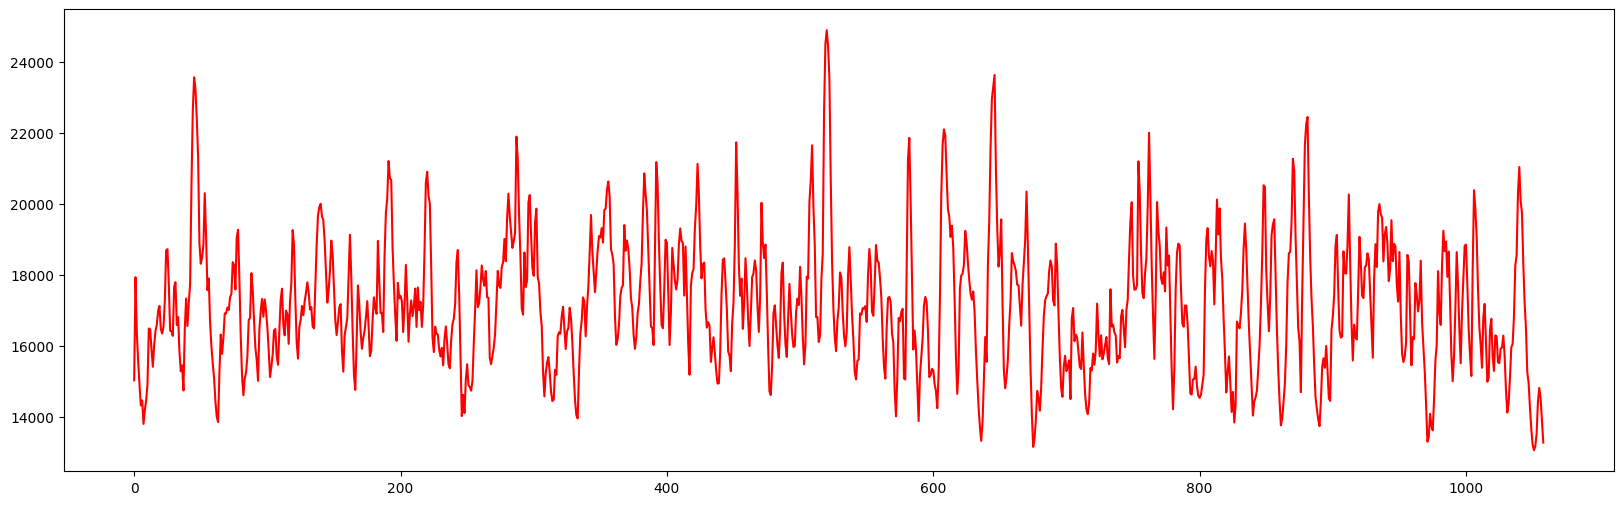

In [25]:
removed_signal = removal(dfs[0]['delta_t'].to_list(), 2)
plot_series(removed_signal)
plt.show()

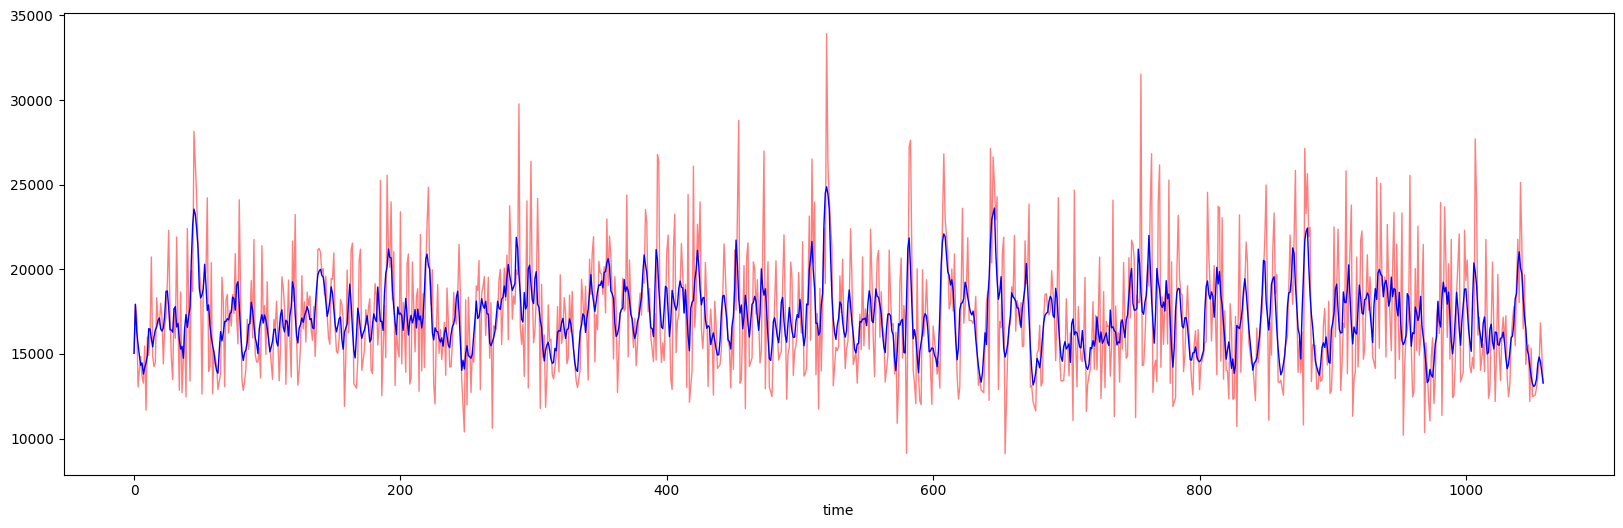

In [26]:
plot_compare(dfs[0]['delta_t'].to_list(), removed_signal)

In [27]:
def lpfilter(input_signal, win):
    # Low-pass linear Filter
    # (2*win)+1 is the size of the window that determines the values that influence 
    # the filtered result, centred over the current measurement
    from scipy import ndimage
    kernel = np.lib.pad(np.linspace(1,3,win), (0,win-1), 'reflect') 
    kernel = np.divide(kernel,np.sum(kernel)) # normalise
    output_signal = ndimage.convolve(input_signal, kernel) 
    return output_signal

In [28]:
from scipy.signal import butter, filtfilt, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [29]:
def smooth(data, box_pts):
    box = np.ones(box_pts)/box_pts
    data_smooth = np.convolve(data, box, mode='same')
    return data_smooth

def smooth_2(data, windows_size, poly_order):
    from scipy.signal import savgol_filter
    data_hat = savgol_filter(data, windows_size, poly_order)
    return data_hat

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [30]:
x = np.array(dfs[0]['delta_t'].to_list())

In [31]:
### smooth data using def
smoothed_2 = lpfilter(dfs[0]['delta_t'].to_list(), 4)
# smoothed = smooth(removed_signal, 3)
# smoothed = smooth_2(dfs[0]['delta_t'].to_list(), 7, 3)
# smoothed = anchor(removed_signal, 0.7)
smoothed = butter_lowpass_filter(dfs[0]['delta_t'].to_list(), cutoff=2, fs=8, order=2)

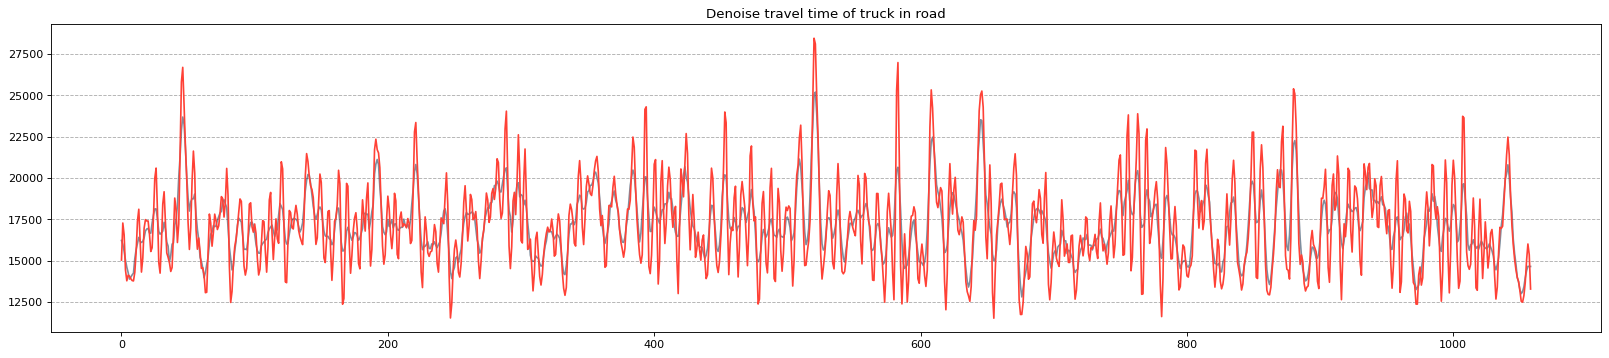

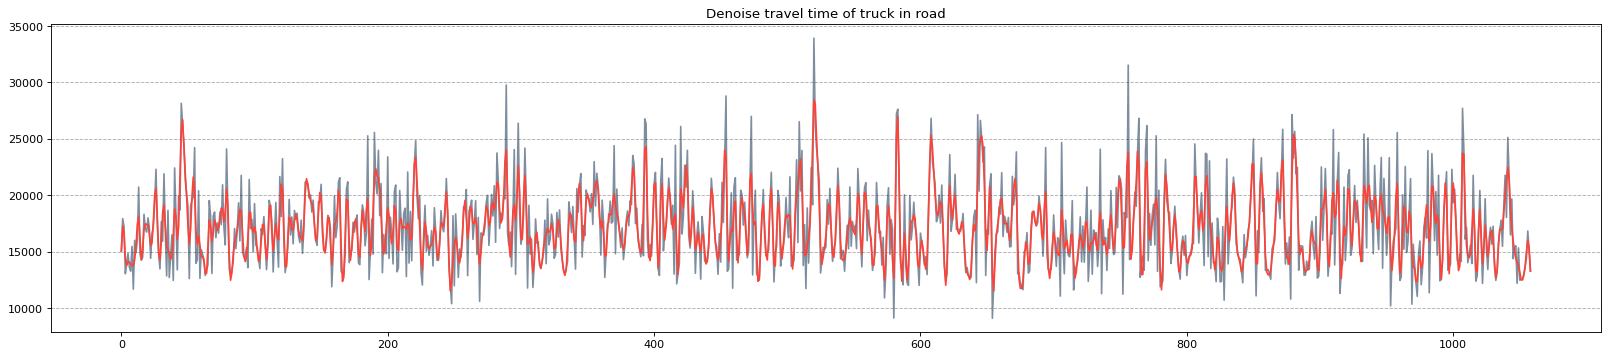

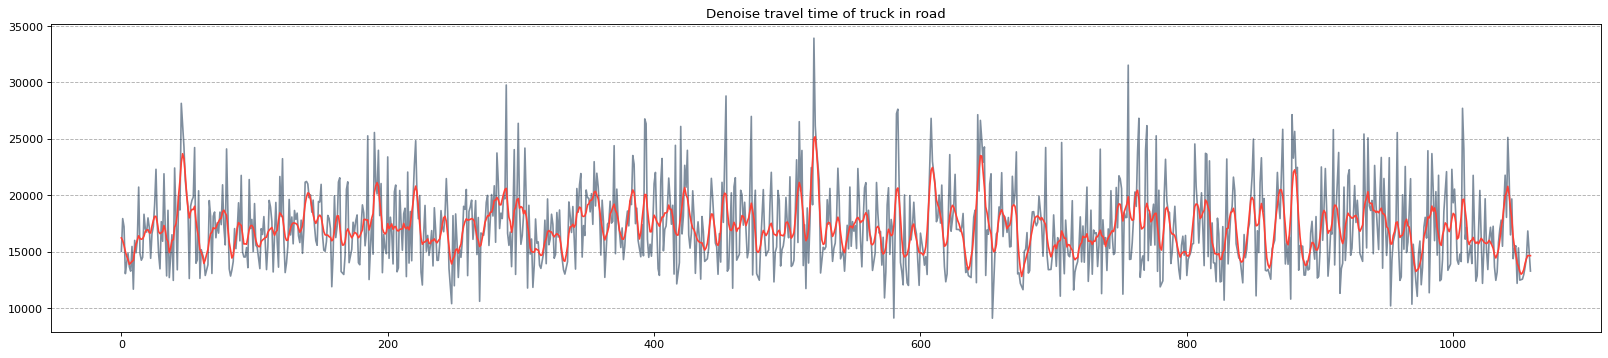

In [67]:
# plot_compare(removed_signal, smoothed)
plot_compare(smoothed_2, smoothed)
plot_compare(dfs[0]['delta_t'].to_list(), smoothed)
plot_compare(dfs[0]['delta_t'].to_list(), smoothed_2)

In [33]:
# denoise = denoise_wavelet(dfs[3]['delta_t'], method='BayesShrink', mode='soft', wavelet_levels=6, wavelet='db2', rescale_sigma='True')

In [34]:
# plot_series(denoise)
# plt.show()

In [35]:
# # plot
# plt.figure(figsize=(20, 6))
# plt.plot(dfs[3]['delta_t'].to_list(), linewidth=1, color='red', alpha=0.5)
# plt.plot(denoise, linewidth=1, color='blue')
# plt.xlabel('time')
# plt.show()

lenght : 1059


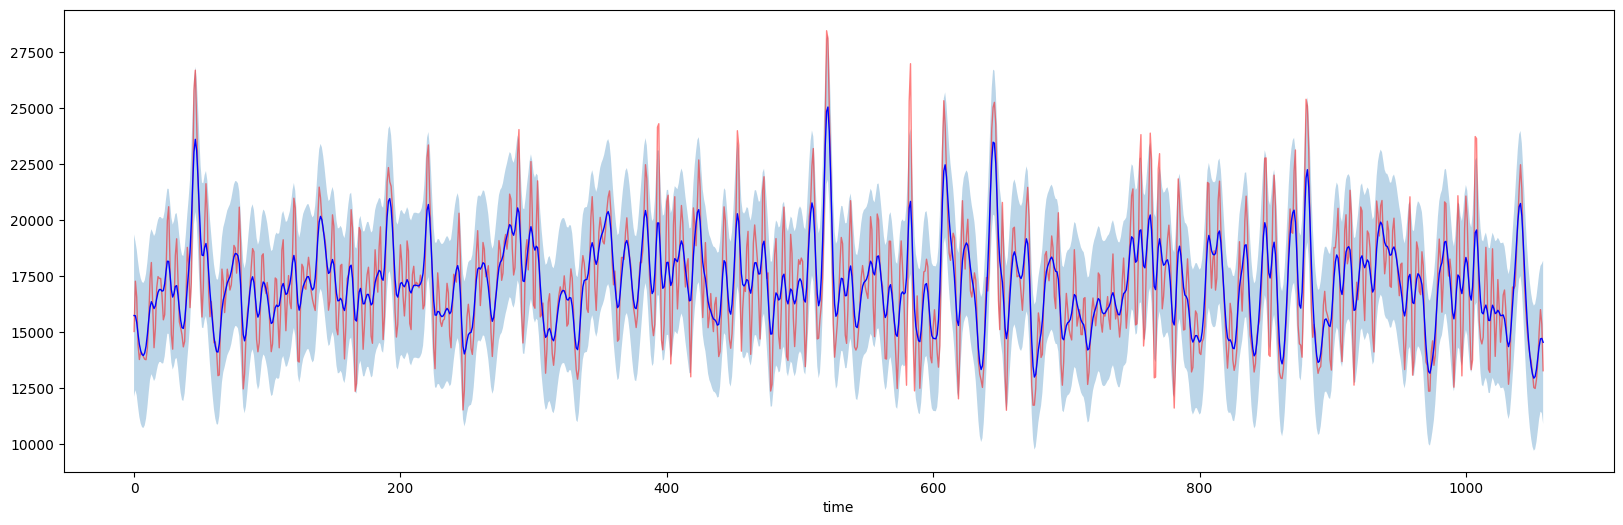

In [36]:
kalman_smooth(smoothed)

In [37]:
for idx, df in enumerate(dfs):
    # removed_signal = removal(df['delta_t'].to_list(), 2)
    # denoise = removed_signal

    # denoise = denoise_wavelet(df['delta_t'], method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    # denoise = denoise_wavelet(df['delta_t'], method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='db2', rescale_sigma='True')
    # denoise = lpfilter(df['delta_t'].to_list(), 3)
    # denoise = smooth(df['delta_t'].to_list(), 4)
    # denoise = smooth_2(removed_signal, 7, 3)
    # denoise = exponential_smoothing(df['delta_t'].to_list(), 0.4)
    # denoise = anchor(df['delta_t'].to_list(), 0.6)
    denoise = butter_lowpass_filter(df['delta_t'].to_list(), cutoff=3, fs=10, order=2)
    dfs[idx]['denoise'] = denoise

    # operate smoothing
    smoother = KalmanSmoother(component='level_trend', component_noise={'level':0.1, 'trend':0.1})
    smoother.smooth(denoise)

    dfs[idx]['smooth'] = smoother.smooth_data[0]

# Data preparation: normalize raw data

In [38]:
class Normalizer:
    def __init__(self):
        self.data = None
        self.std_diff = 0
        self.mean_diff = 0

    def fit_transform(self, data):
        self.data = data

        # first difference
        diff_data = data.diff().fillna(data)

        # normalize
        self.mean_diff, self.std_diff = diff_data.mean(), diff_data.std()
        normalize_data = (diff_data - self.mean_diff) / self.std_diff

        return normalize_data

    def inverse_transform(self, data, split_data_index=0):
        inverse_data = []
        for idx in range(len(data)):
            # check first data
            if (idx + split_data_index) == 0:
                _data = (data[idx] * self.std_diff) + self.mean_diff + self.data[0]
            else:
                _data = (data[idx] * self.std_diff) + self.mean_diff + self.data[(idx - 1) + split_data_index]
            inverse_data.append(_data)

        inverse_series = pd.Series(inverse_data, index=data.index)

        return inverse_series

In [39]:
scaler_list = [Normalizer() for _ in range(len(dfs))]
normalize_data_list = [scaler_list[idx].fit_transform(dfs[idx]['denoise']) for idx in range(len(dfs))]

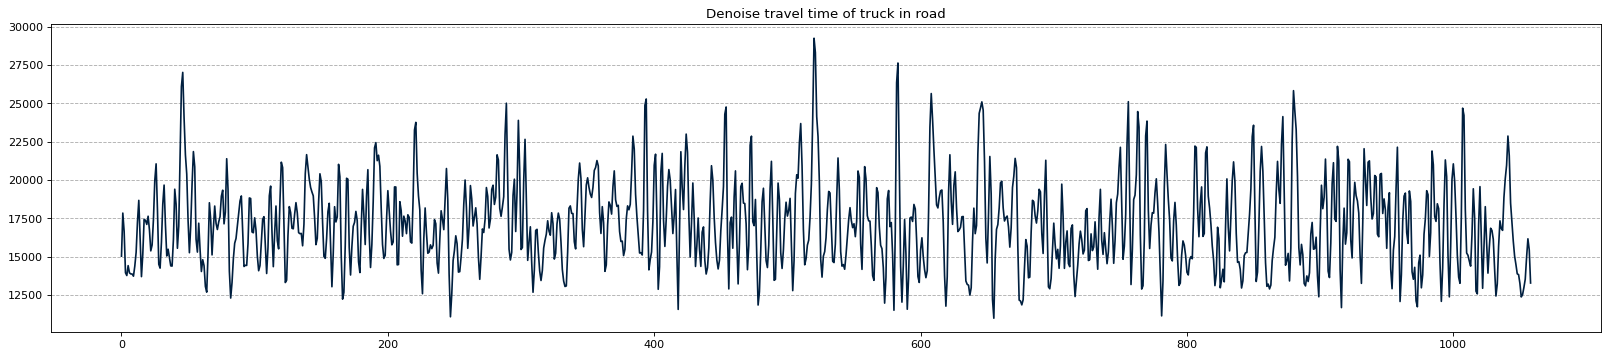

In [63]:
plot_actual(dfs[0]['denoise'])

road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
path = cfg['data']['path'].split('/')[-2]
plt.title(f"Travel time of truck in rode {road} ({path}) - show normailze data")

plt.show()

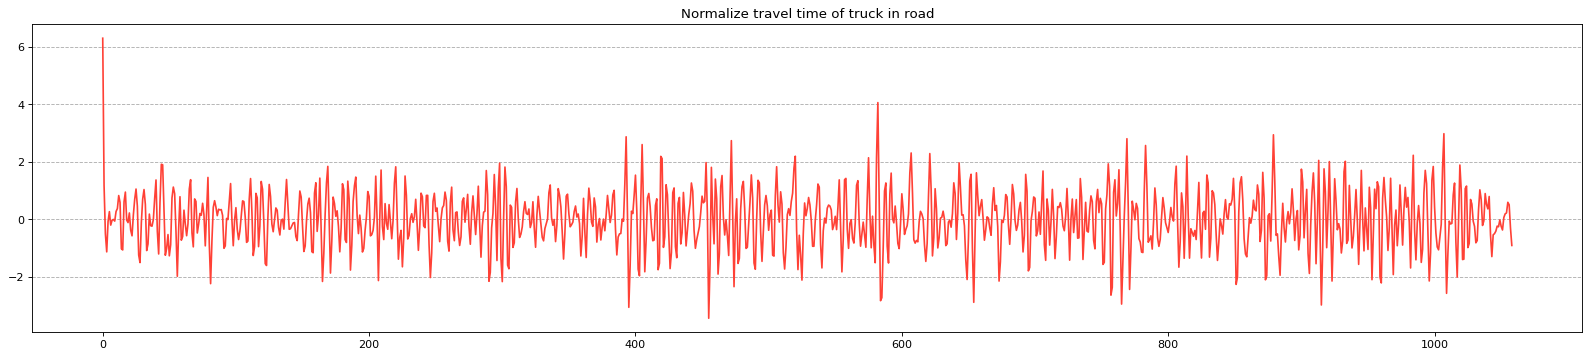

In [65]:
plot_actual_2(normalize_data_list[0])

road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
path = cfg['data']['path'].split('/')[-2]
plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")

plt.show()

# Data preparation: generating training, test and validation data

In [40]:
def preprocess(data, window_size):
    X, y, y_date = [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i].to_list())
        y.append(data[i])
        y_date.append(data.index[i])
    return np.array(X), np.array(y), np.array(y_date)

def generate_train_test_val(normalize_data, num_data_points, scaler, cfg, plot=False):
    data_x, data_y, data_date_y = preprocess(normalize_data, cfg['data']['window_size'])
    
    # init split index
    split_train_index = int(data_x.shape[0] * cfg['data']['train_split_size'])
    split_val_index = int(data_x.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

    # split data for train test model
    # split data x
    data_x_train = data_x[:split_train_index]
    data_x_val = data_x[split_train_index:split_val_index]
    data_x_test = data_x[split_val_index:]

    # split data y
    data_y_train = data_y[:split_train_index]
    data_date_y_train = data_date_y[:split_train_index]
    data_y_val = data_y[split_train_index:split_val_index]
    data_date_y_val = data_date_y[split_train_index:split_val_index]
    data_y_test = data_y[split_val_index:]
    data_date_y_test = data_date_y[split_val_index:]

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)
        

        data_y_train_series = pd.Series(data_y_train, index=data_date_y_train)
        data_y_val_series = pd.Series(data_y_val, index=data_date_y_val)
        data_y_test_series = pd.Series(data_y_test, index=data_date_y_test)


        to_plot_data_y_train[cfg['data']['window_size']:split_train_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_train_series, cfg['data']['window_size'])
        to_plot_data_y_val[split_train_index + cfg['data']['window_size']:split_val_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_val_series, split_train_index + cfg['data']['window_size'])
        to_plot_data_y_test[split_val_index + cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test_series, split_val_index + cfg['data']['window_size'])

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        idx = np.arange(0, len(normalize_data))

        # plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
        plt.plot(idx, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
        plt.plot(idx, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, split_train_index, split_val_index


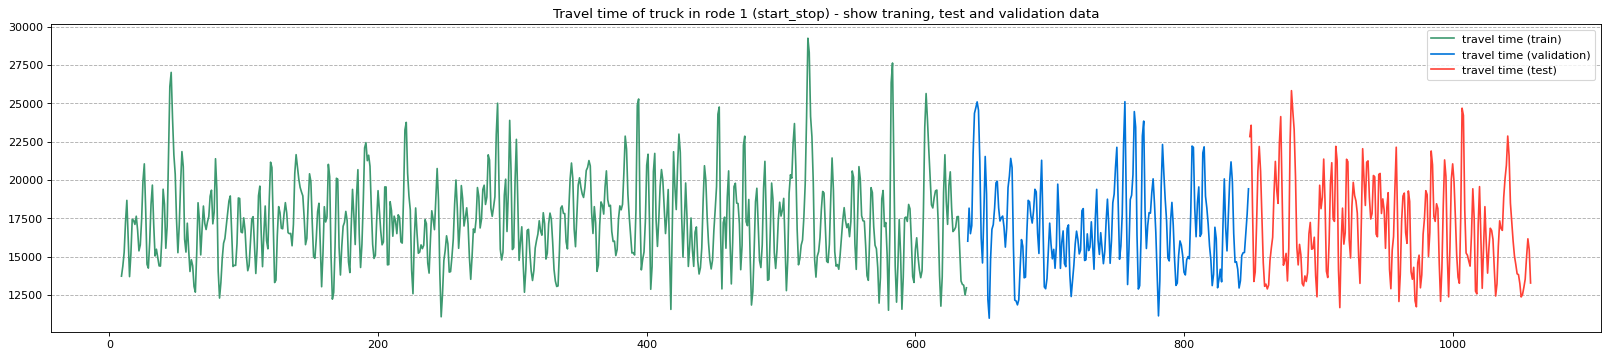

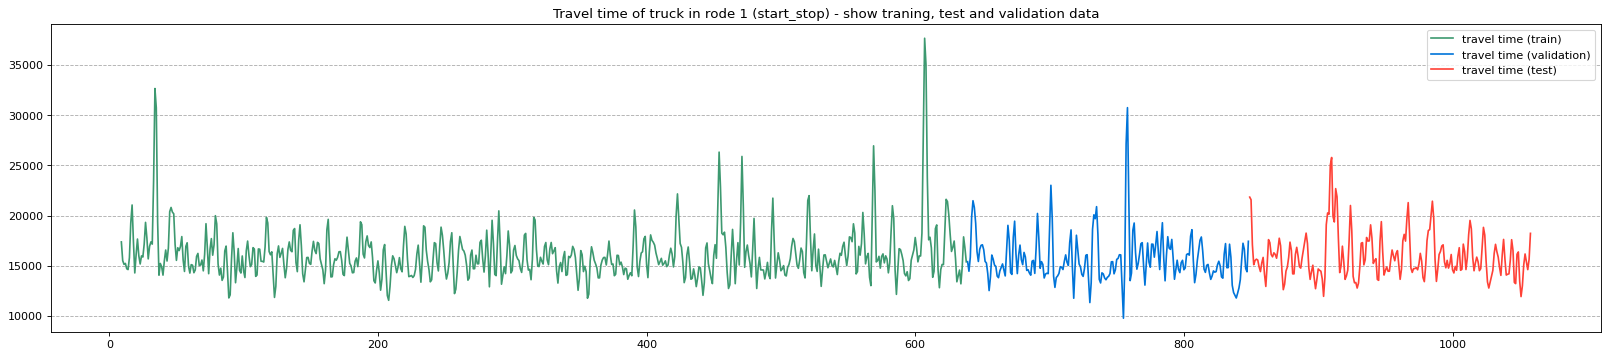

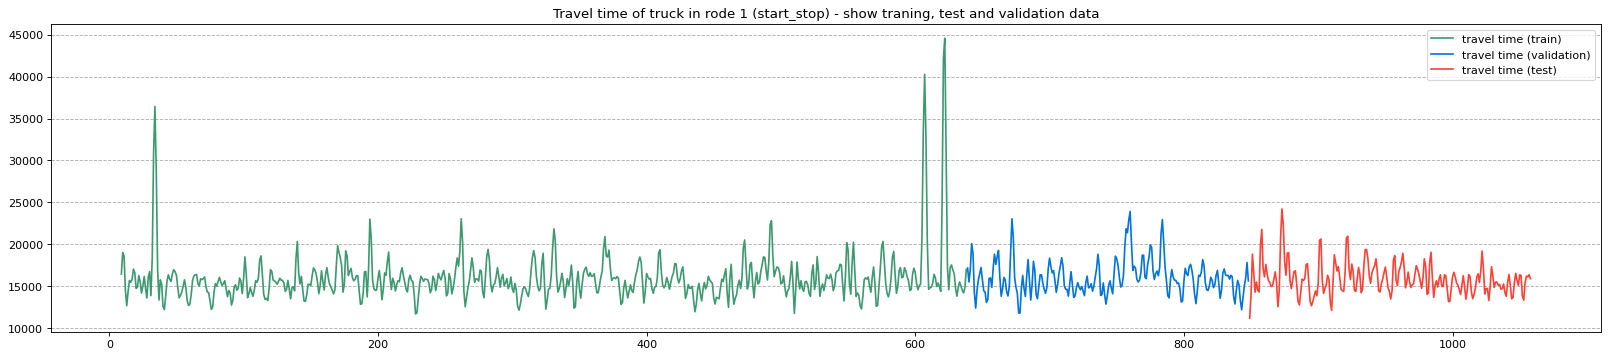

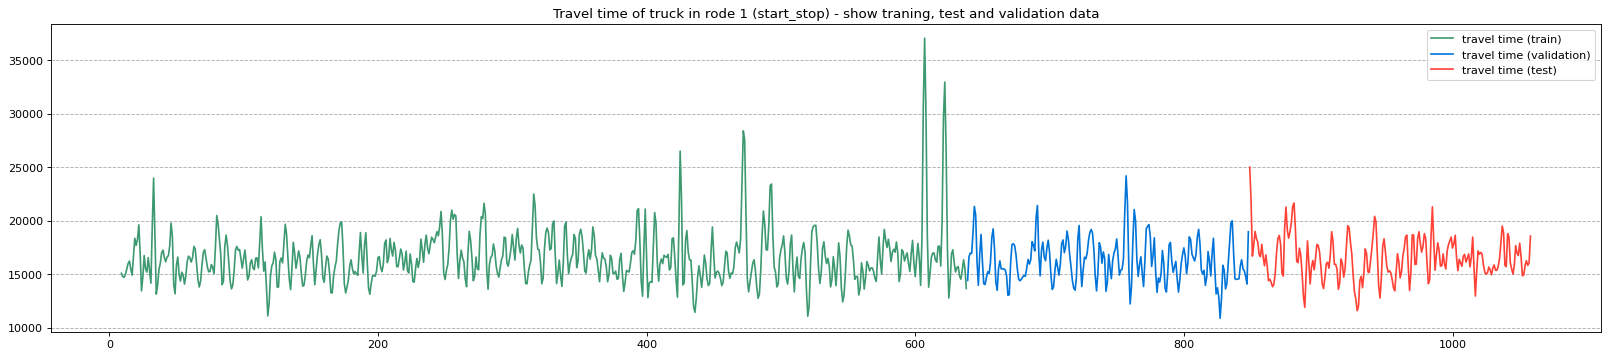

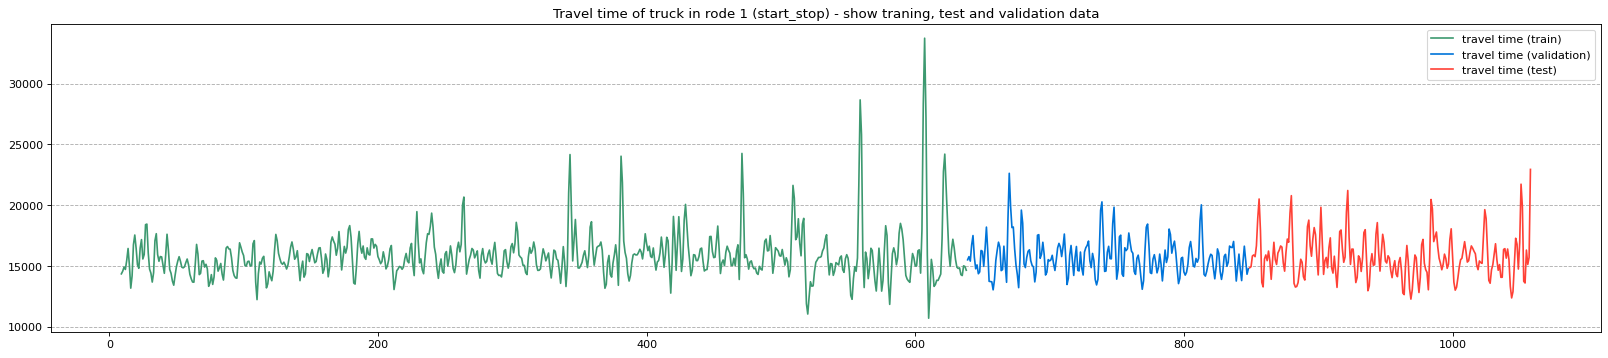

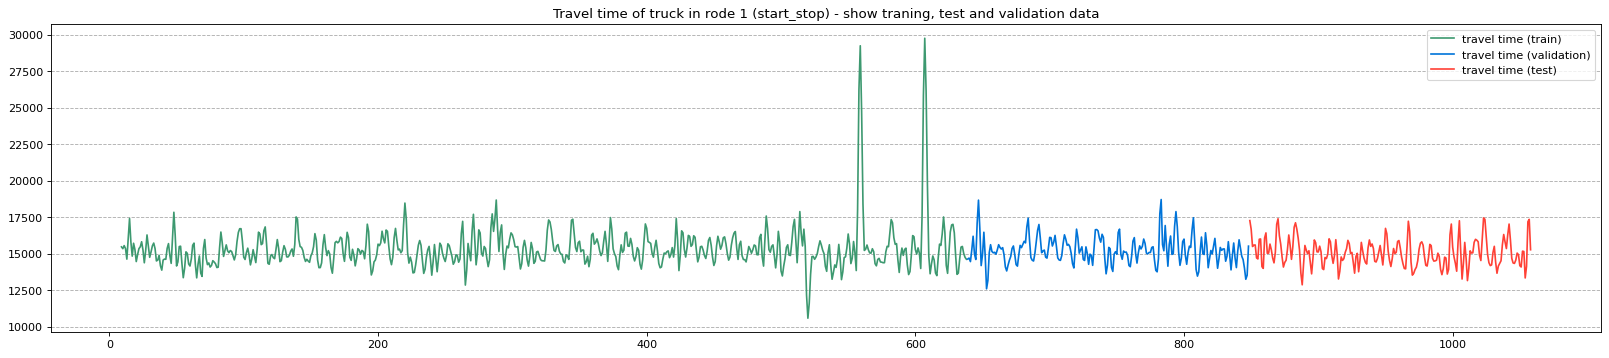

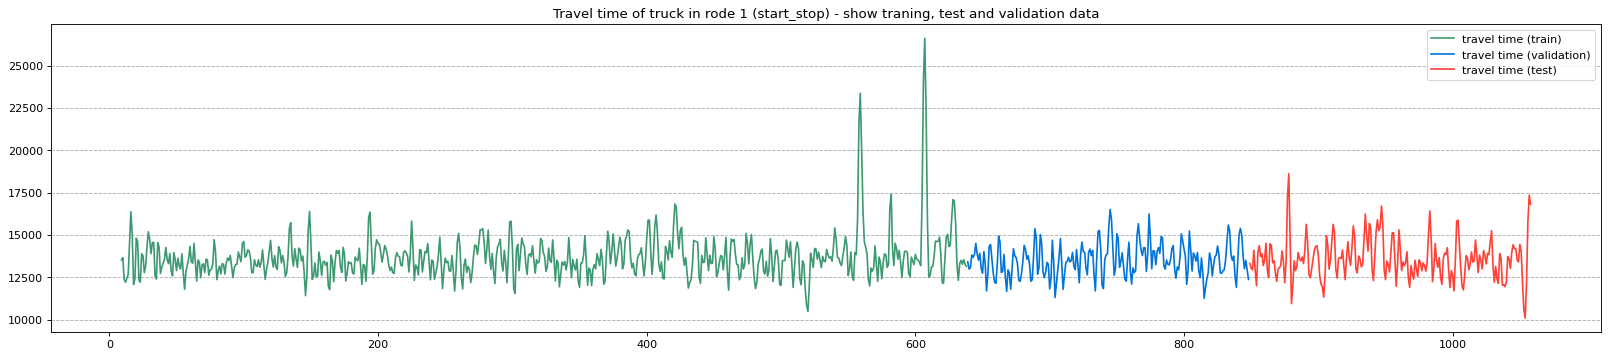

In [41]:
data_x_train_list, data_x_val_list, data_x_test_list, data_y_train_list, data_y_val_list, data_y_test_list, data_date_y_test_list, split_val_index_list = [], [], [], [], [], [], [], []
for idx in range(len(normalize_data_list)):
    data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, _, split_val_index = generate_train_test_val(normalize_data_list[idx], num_data_points_list[idx], scaler_list[idx], cfg, True)
    data_x_train_list.append(data_x_train)
    data_x_val_list.append(data_x_val)
    data_x_test_list.append(data_x_test)
    data_y_train_list.append(data_y_train)
    data_y_val_list.append(data_y_val)
    data_y_test_list.append(data_y_test)
    data_date_y_test_list.append(data_date_y_test)
    split_val_index_list.append(split_val_index)

In [37]:
for idx in range(len(data_x_train_list)):
    print(f"time: {idx}")
    print(f"Train data shape: {data_x_train_list[idx].shape} {data_y_train_list[idx].shape}")
    print(f"Validation data shape: {data_x_val_list[idx].shape} {data_y_val_list[idx].shape}")
    print(f"Test data shape: {data_x_test_list[idx].shape} {data_y_test_list[idx].shape}")

time: 0
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 1
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 2
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 3
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 4
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 5
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 6
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)


In [38]:
dataset_train, dataset_val, dataset_test = [], [], []
for idx in range(len(data_x_train_list)):
    dataset_train.append(TravelTimeDataset(data_x_train_list[idx], data_y_train_list[idx]))
    dataset_val.append(TravelTimeDataset(data_x_val_list[idx], data_y_val_list[idx]))
    dataset_test.append(TravelTimeDataset(data_x_test_list[idx], data_y_test_list[idx]))
    print(f"time : {idx}")
    print(f"Train data for model shape: {dataset_train[idx].x.shape} {dataset_train[idx].y.shape}")
    print(f"Validation data for model shape: {dataset_val[idx].x.shape} {dataset_val[idx].y.shape}")
    print(f"Test data for model shape: {dataset_test[idx].x.shape} {dataset_test[idx].y.shape}")

time : 0
Train data for model shape: (630, 9, 1) (630,)
Validation data for model shape: (210, 9, 1) (210,)
Test data for model shape: (210, 9, 1) (210,)
time : 1
Train data for model shape: (630, 9, 1) (630,)
Validation data for model shape: (210, 9, 1) (210,)
Test data for model shape: (210, 9, 1) (210,)
time : 2
Train data for model shape: (630, 9, 1) (630,)
Validation data for model shape: (210, 9, 1) (210,)
Test data for model shape: (210, 9, 1) (210,)
time : 3
Train data for model shape: (630, 9, 1) (630,)
Validation data for model shape: (210, 9, 1) (210,)
Test data for model shape: (210, 9, 1) (210,)
time : 4
Train data for model shape: (630, 9, 1) (630,)
Validation data for model shape: (210, 9, 1) (210,)
Test data for model shape: (210, 9, 1) (210,)
time : 5
Train data for model shape: (630, 9, 1) (630,)
Validation data for model shape: (210, 9, 1) (210,)
Test data for model shape: (210, 9, 1) (210,)
time : 6
Train data for model shape: (630, 9, 1) (630,)
Validation data for 

# Define model

In [39]:
class CNN_Block(nn.Module):
    def __init__(self):
        super(CNN_Block, self).__init__()
        self.conv_1_out = [32, 64, 128]
        self.conv_2_out = [32, 64, 128]
        self.conv_kernel_size = [2, 3]

        self.conv_1 = nn.Conv1d(1, 32, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_2 = nn.Conv1d(32, 64, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_3 = nn.Conv1d(64, 64, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_4 = nn.Conv1d(64, 64, kernel_size=self.conv_kernel_size[0], stride=1)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        # out = F.relu(self.conv_3(out))
        # out = F.relu(self.conv_4(out))
        # out = self.maxpool_1(out)

        # out = self.conv_1(x)

        return out

In [40]:
class LSTM_Block(nn.Module):
    def __init__(self):
        super(LSTM_Block, self).__init__()
        self.lstm_in = [32, 64, 128]
        self.lstm_hidden = [64, 128, 200, 256]
        self.linear_out = [32, 64]
        self.dropout = [0.1, 0.2, 0.3]

        self.lstm_1 = nn.LSTM(
            input_size=64,
            hidden_size=200,
            num_layers=2,
            batch_first=True,
        )
        self.fc_1 = nn.Linear(200, 64)
        self.dropout_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(32, 16)
        self.dropout_2 = nn.Dropout(0.1)

    def forward(self, x):
        out, _ = self.lstm_1(x)
        out = out[:, -1, :]
        out = F.relu(self.fc_1(out))
        out = self.dropout_1(out)
        # out = F.relu(self.fc_2(out))
        # out = self.dropout_2(out)

        return out

In [41]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.linear_in = [32, 64]
        self.cnn_block = CNN_Block()
        self.lstm_block = LSTM_Block()
        self.out_block = nn.Linear(64, 1)

    def forward(self, x):
        # CNN block
        out = self.cnn_block(x)

        out = out.view(out.shape[0], out.shape[2], out.shape[1])

        # LSTM block
        out = self.lstm_block(out)
        
        # Output layer
        out = self.out_block(out)

        return out

In [42]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=200, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(200, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [43]:
class AttentionalLSTM(nn.Module):
    def __init__(self, input_size, qkv, hidden_size, num_layers, output_size, bidirectional=False):
        super(AttentionalLSTM, self).__init__()

        self.input_size = input_size
        self.qkv = qkv
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.query = nn.Linear(input_size, qkv)
        self.key = nn.Linear(input_size, qkv)
        self.value = nn.Linear(input_size, qkv)

        self.attn = nn.Linear(qkv, input_size)
        self.scale = math.sqrt(qkv)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.dropout = nn.Dropout(0.2)
        
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(x.shape)
        Q, K, V = self.query(x), self.key(x), self.value(x)

        dot_product = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        scores = torch.softmax(dot_product, dim=-1)
        scaled_x = torch.matmul(scores, V) + x

        out = self.attn(scaled_x) + x

        # print(f"out : {out.shape}")

        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        # print(out.shape)
        out = self.fc(out)

        return out

In [44]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# Model training

In [45]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    # optimizer = optim.RMSprop(model.parameters(), lr=cfg['optimizer']['lr'])
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'], betas=(0.5, 0.999))
    # optimizer = optim.Adadelta(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=False, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        # print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'], dtype=torch.float32)
            y = y.to(cfg['train']['device'], dtype=torch.float32)
            
            # prediction
            pred = model(x)
            loss = criterion(pred[:,0], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'], dtype=torch.float32)
            y = y.to(cfg['train']['device'], dtype=torch.float32)

            pred = model(x)
            loss = criterion(pred[:,0], y)

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

# Model evaluation

In [46]:
def eval(dataset_test, data_date_y_test, split_val_index, scaler, model, cfg, best_model_name, df, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    data_test_y_series = pd.Series(dataset_test.y, index=data_date_y_test)
    predict_test_series = pd.Series(predicted_test, index=data_date_y_test)

    # mse = mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    # rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    # mae = mean_absolute_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    # r2 = r2_score(dataset_test.y, predicted_test)

    rmse_min = math.sqrt(mean_squared_error(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size'])))
    mae_min = mean_absolute_error(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']))
    r2_min = r2_score(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']))
    # print(f"Minimum error || rmse: {rmse_min} || mae: {mae_min} || r2: {r2_min}")
    # print(len(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list()))
    # print(len(scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    # print(len(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list()))
    # print(len(scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    # print(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list())
    # print(scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    mse = mean_squared_error(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    rmse = math.sqrt(mean_squared_error(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    mae = mean_absolute_error(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    r2 = r2_score(df['delta_t'][split_val_index + cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size'])
        to_plot_predicted_test = scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])

        idx = np.arange(0, len(predict_test_series[:]))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, data_test_y_series, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, predict_test_series, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road with first differencec {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test_subset[:], label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test[:], label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road with kalman filter {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, df['delta_t'][split_val_index + cfg['data']['window_size']:], label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test[:], label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road with real data {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae, r2, rmse_min, mae_min, r2_min

# Modified

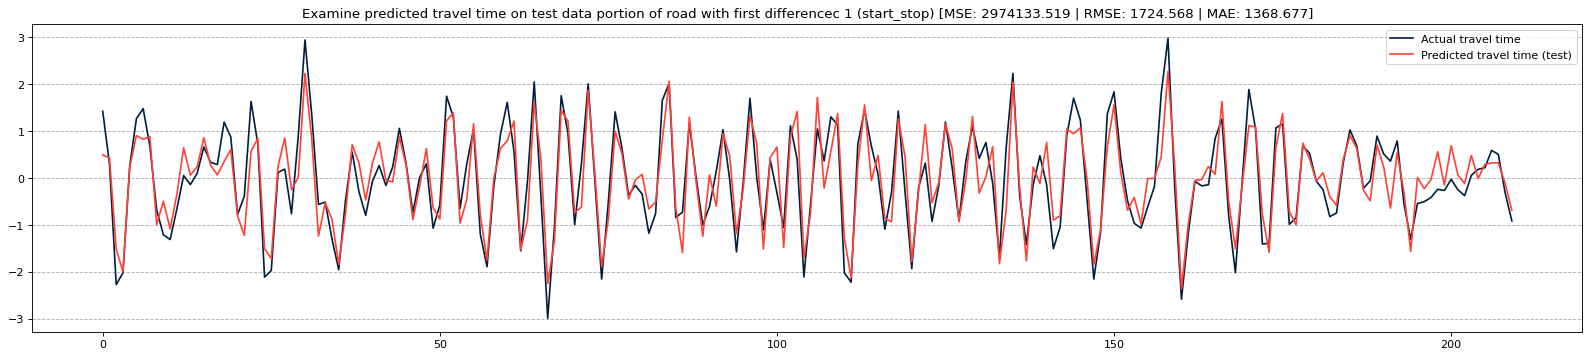

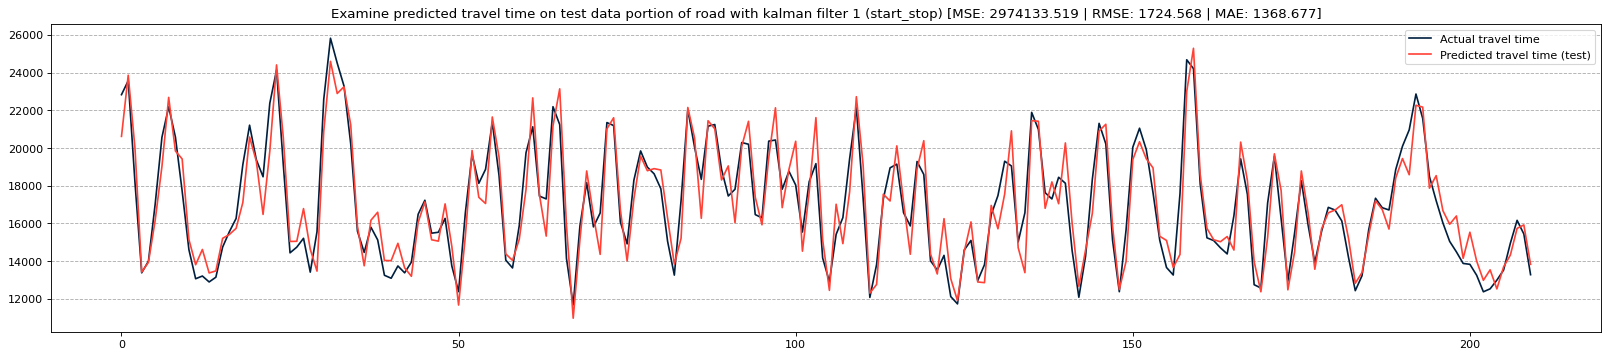

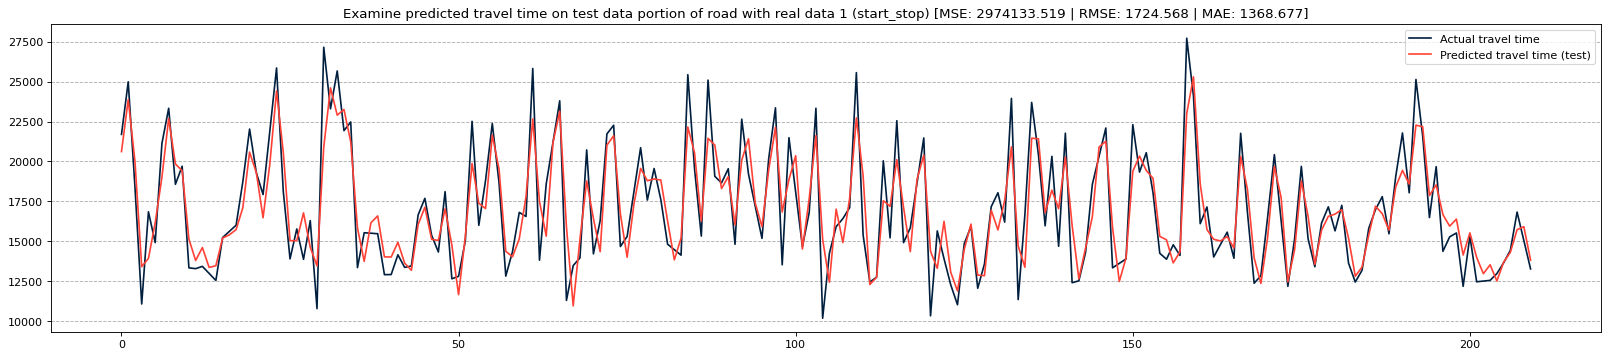

time : 0
MSE : 2974133.5192569857 || RMSE : 1724.5676325551822 || MAE : 1368.6770314773082


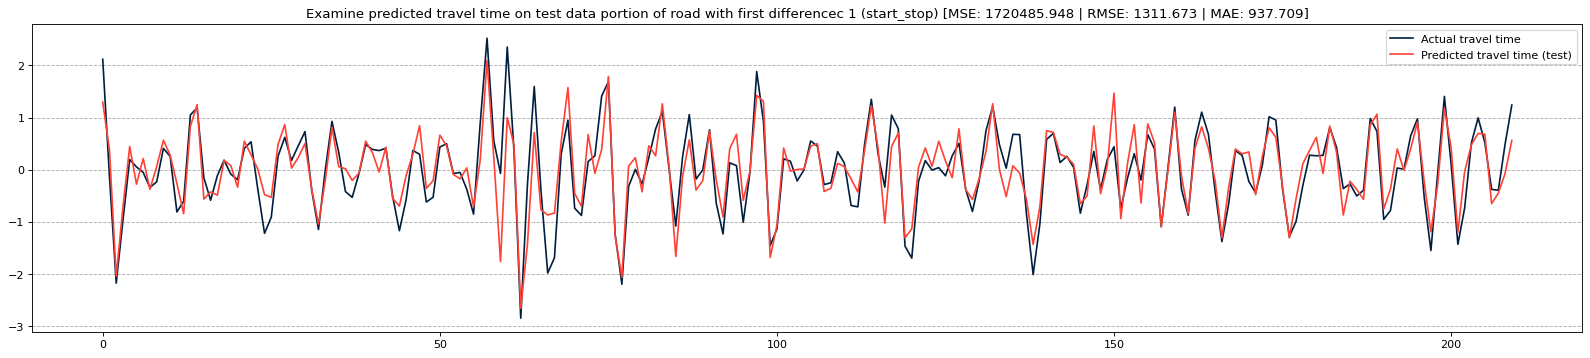

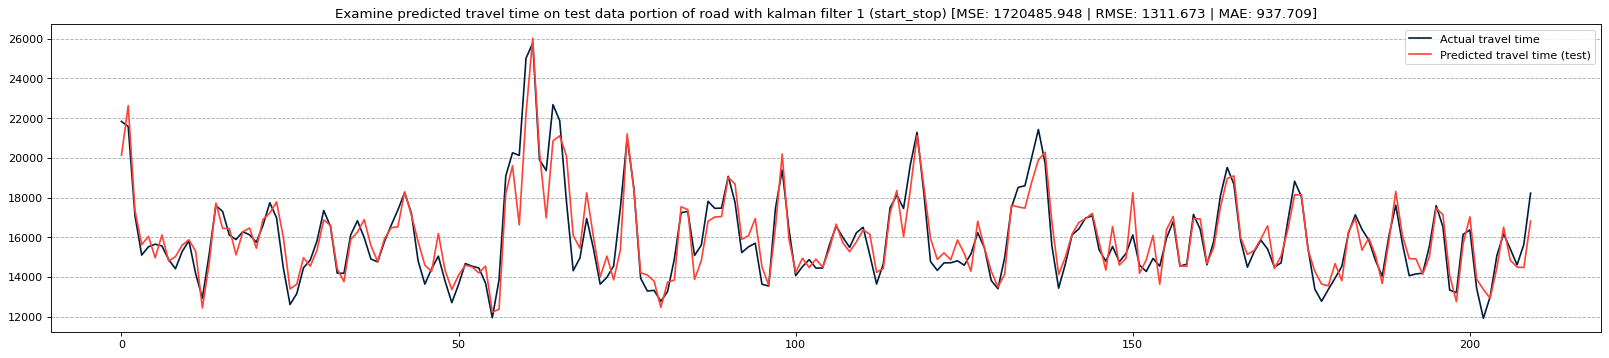

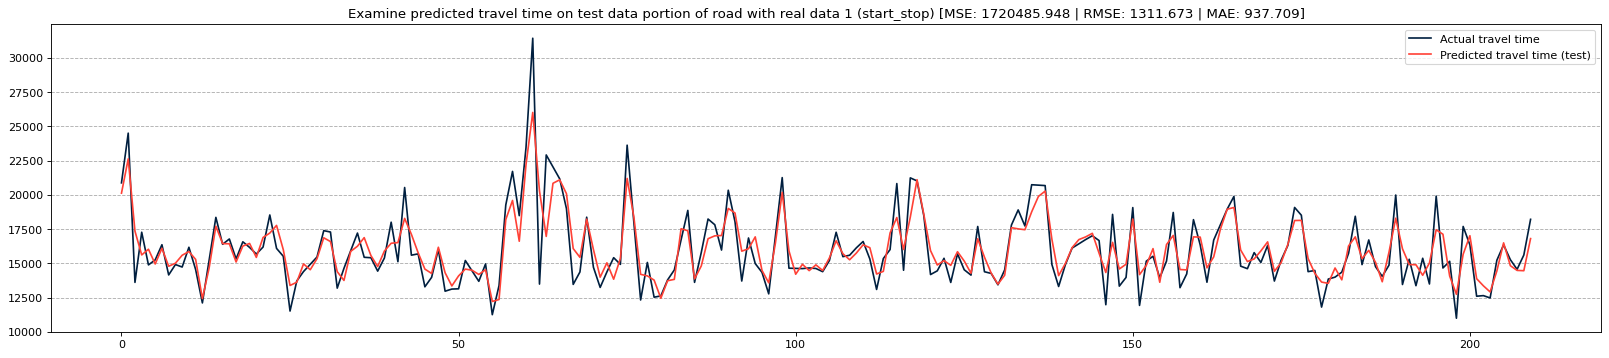

time : 1
MSE : 1720485.947793103 || RMSE : 1311.6729576358214 || MAE : 937.7086609583334


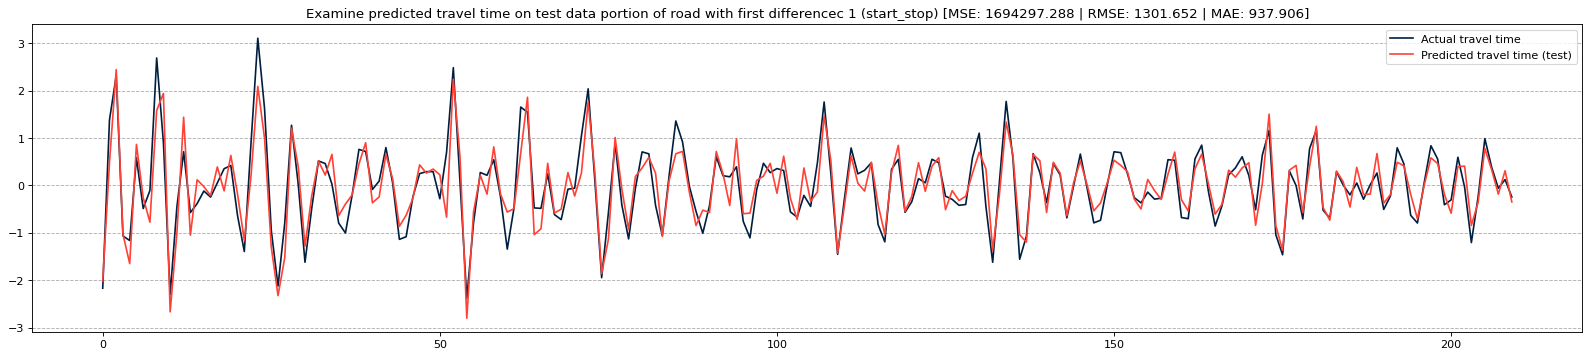

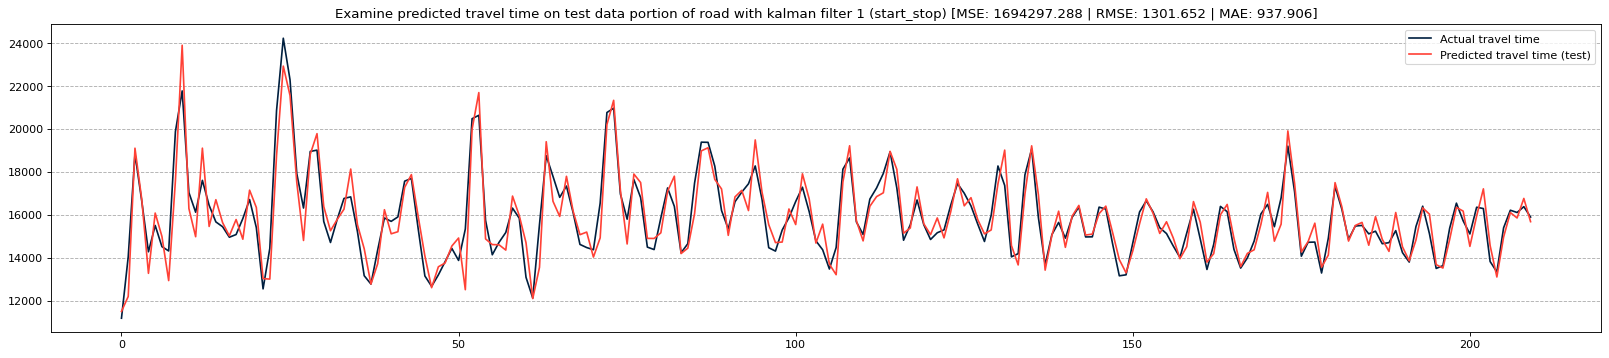

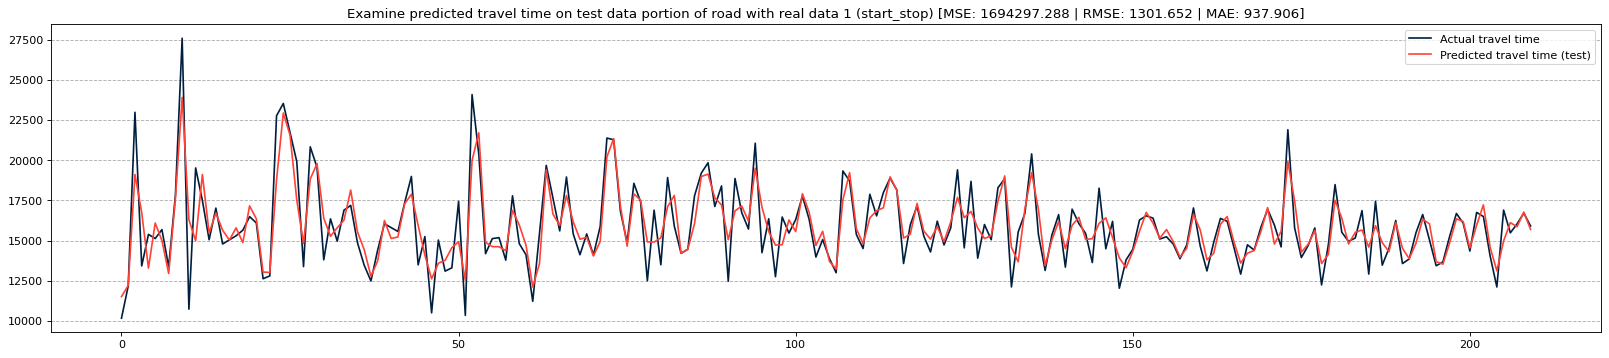

time : 2
MSE : 1694297.2875756493 || RMSE : 1301.6517535714572 || MAE : 937.9060449663218


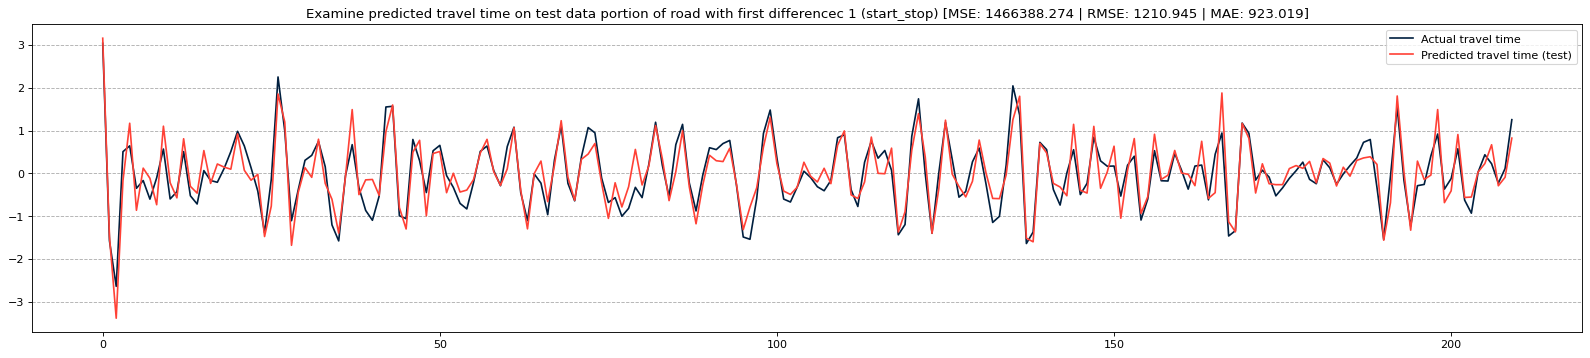

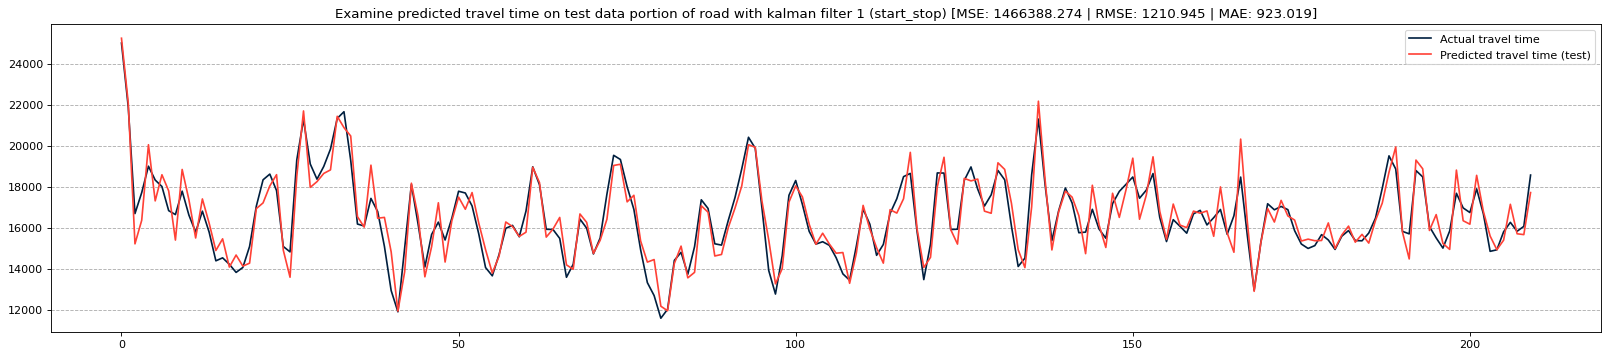

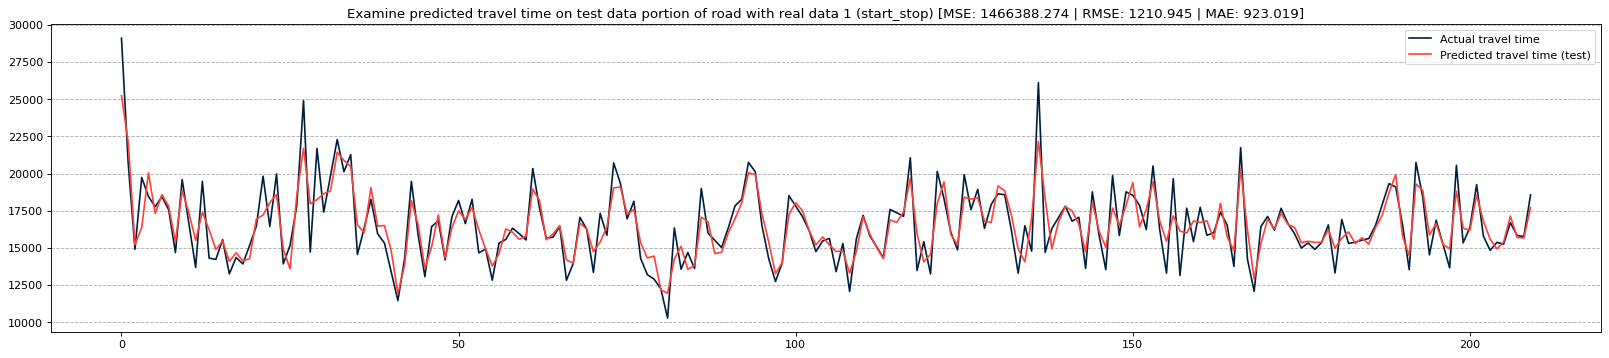

time : 3
MSE : 1466388.2736565305 || RMSE : 1210.945198453064 || MAE : 923.0185654180382


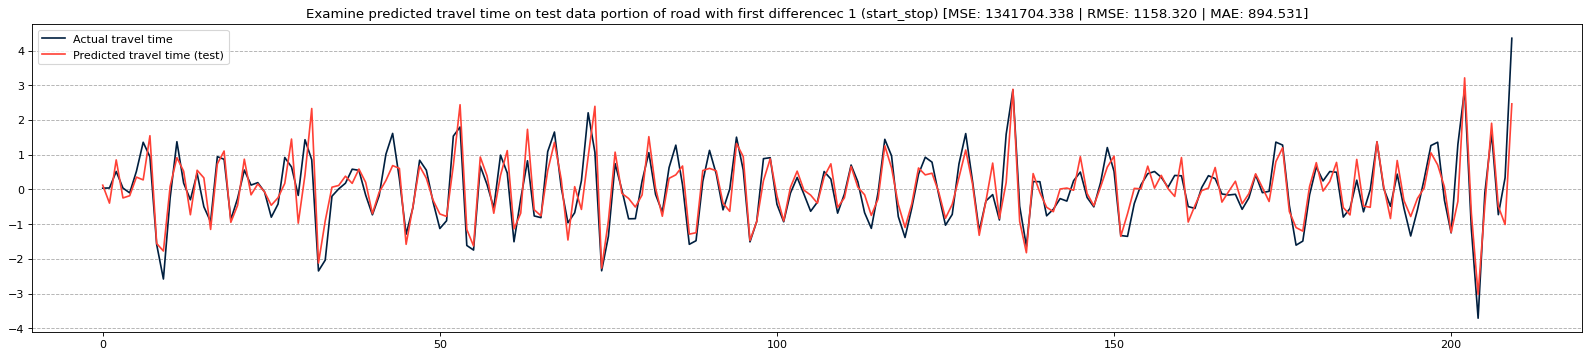

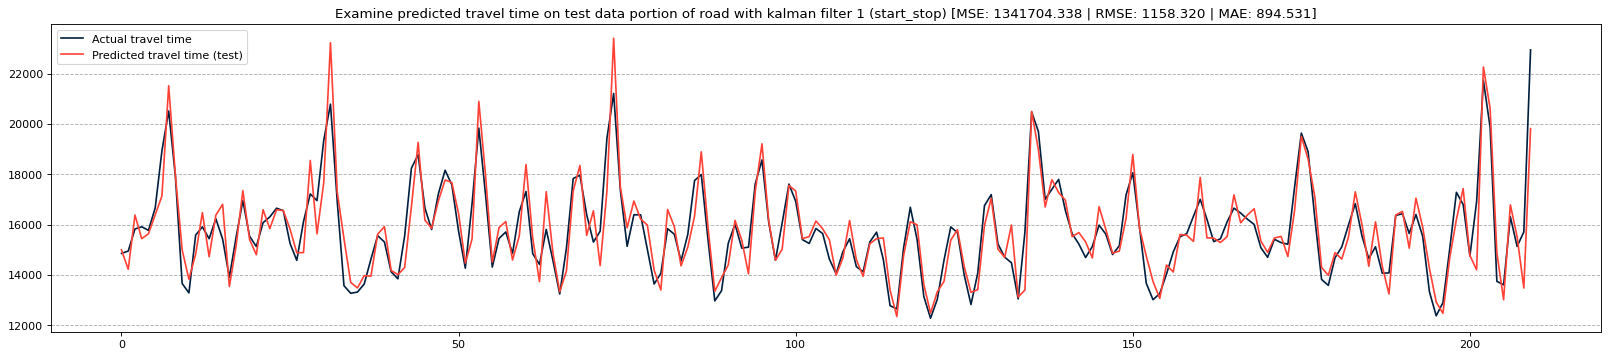

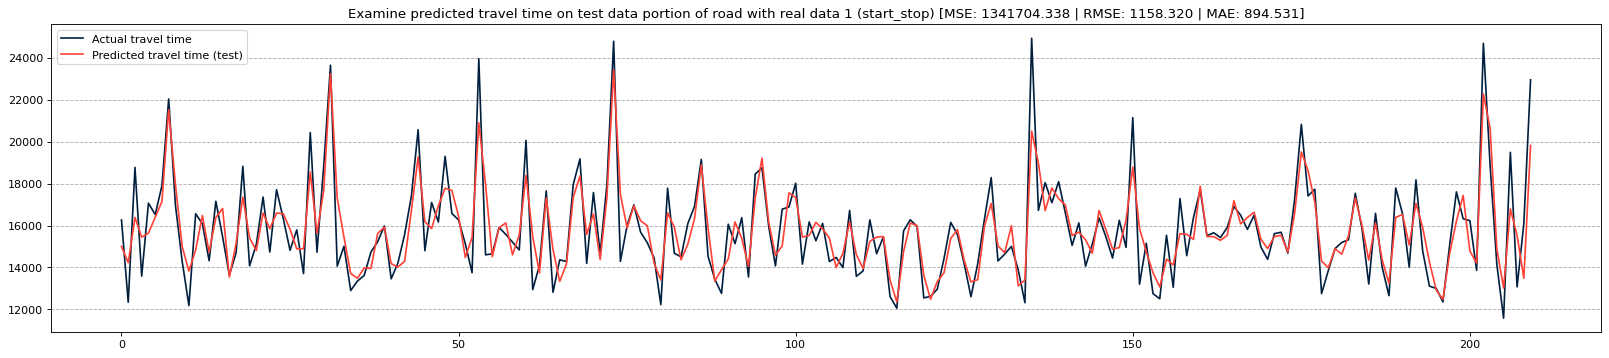

time : 4
MSE : 1341704.3378374707 || RMSE : 1158.3196181699898 || MAE : 894.5306361194732


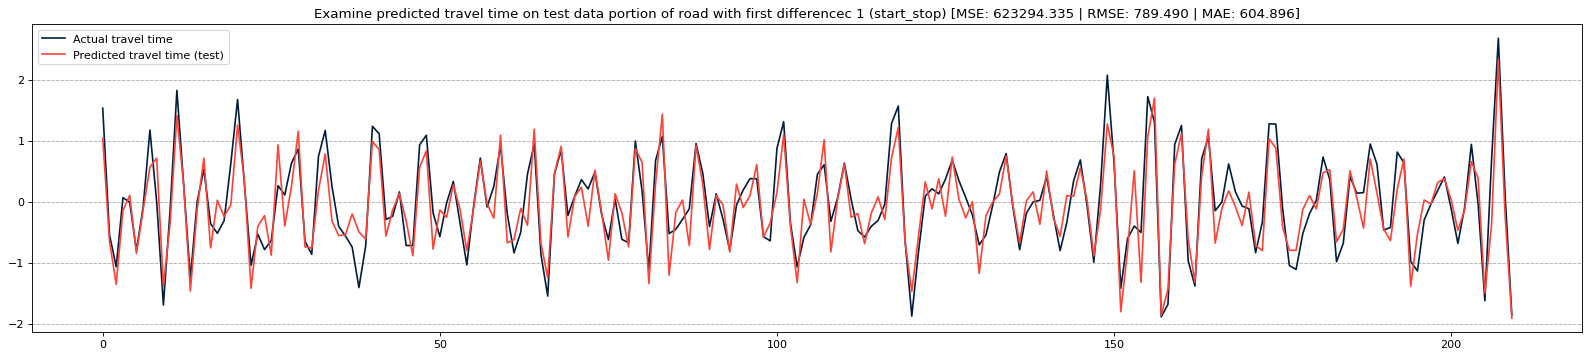

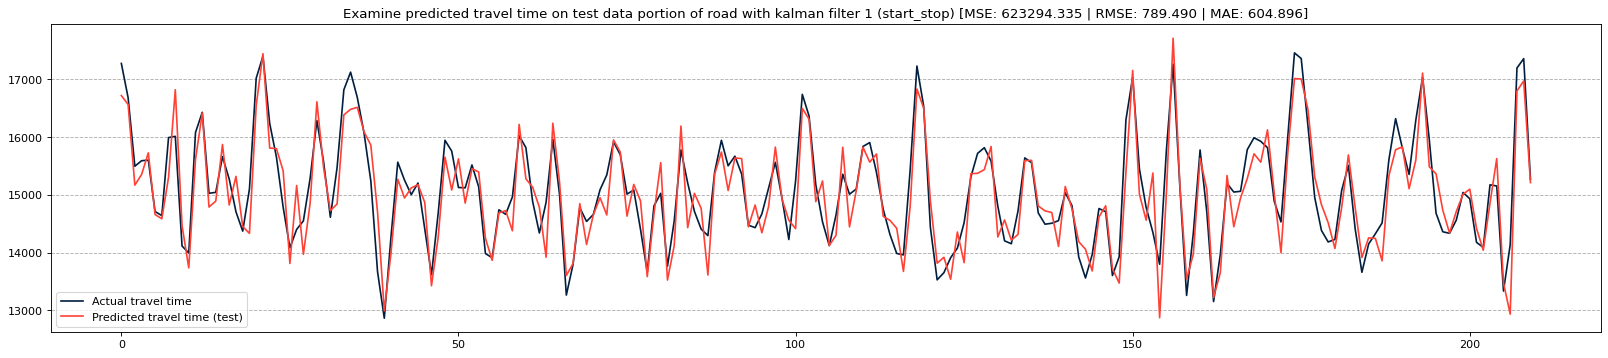

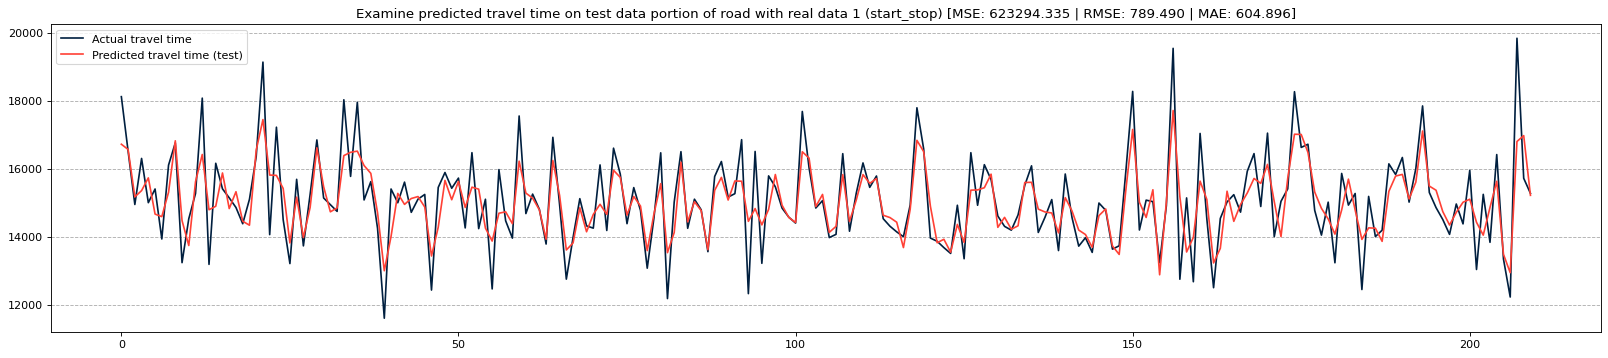

time : 5
MSE : 623294.3347846912 || RMSE : 789.489920635274 || MAE : 604.8956693502735


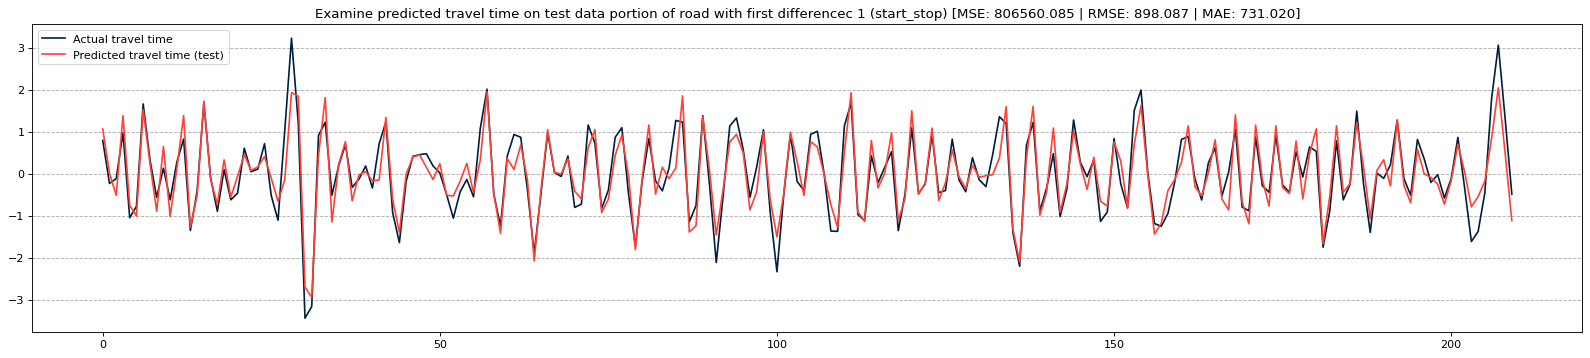

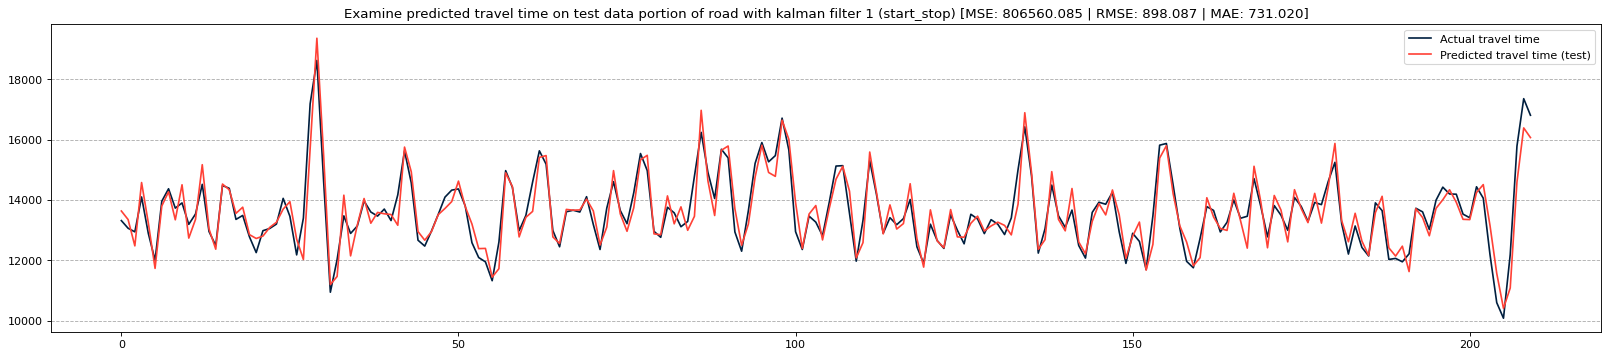

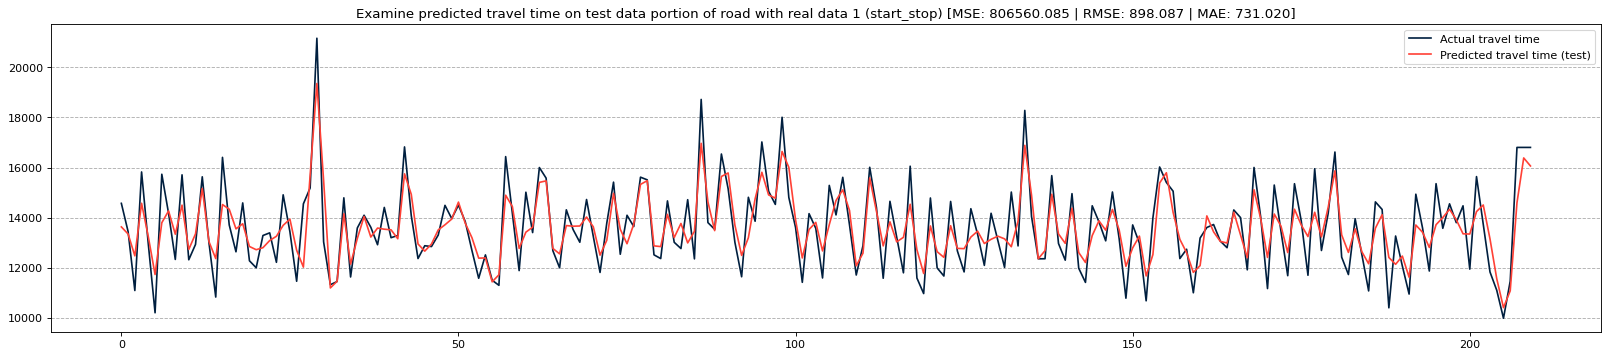

time : 6
MSE : 806560.0846521261 || RMSE : 898.0869026169606 || MAE : 731.0199889468695


In [55]:
result = []
for idx in range(len(dataset_train)):
    # model = ConvLSTM_Traveltime(1, 32, 3, 1, 1)
    # model = CNN_LSTM()
    # model = LSTM()
    model = AttentionalLSTM(input_size=1, qkv=cfg['data']['window_size'], hidden_size=200, num_layers=2, output_size=1, bidirectional=False)
    model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    train_losses, valid_losses, early_stopping, model = train(dataset_train[idx], dataset_val[idx], model, cfg, idx, 0)

    mse, rmse, mae, r2, rmse_min, mae_min, r2_min = eval(dataset_test[idx], data_date_y_test_list[idx], split_val_index_list[idx], scaler_list[idx], model, cfg, f"attn_lstm_time_{idx}_{0}", dfs[idx],True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'rmse_min': rmse_min,
        'mae_min': mae_min,
        'r2_min': r2_min
    })

report = pd.DataFrame(result)

In [56]:
print(f"Minimum rmse : {report['rmse_min'].mean()}")
print(f"rmse : {report['rmse'].mean()}")

Minimum rmse : 1283.5044873739462
rmse : 1199.2477119482498


In [57]:
print(f"Minimum mae : {report['mae_min'].mean()}")
print(f"mae : {report['mae'].mean()}")

Minimum mae : 960.0368371934172
mae : 913.9652281766597


In [58]:
print(f"Maximum r2 : {report['r2_min'].mean()}")
print(f"r2 : {report['r2'].mean()}")

Maximum r2 : 0.7084972341796133
r2 : 0.7486804340588138
